### Python Notebook to make pulses from Everywhere Class in X-PSI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import NullFormatter
import sys
import scipy
from __future__ import print_function, division

import os
import math
import time

from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
%matplotlib notebook
from ipywidgets import *

In [2]:
import xpsi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 1.2.1               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [3]:
from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

#### Setting up the Spacetime

In [4]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))      # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=571.0))

Creating parameter:
    > Named "frequency" with fixed value 5.710e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


#### Setting up everywhere class [Setting up the grid]

In [5]:
everywhere = xpsi.Everywhere(time_invariant=False,
                            sqrt_num_cells=256,
                            bounds=dict(temperature = (None,None)),
                            mycoolgrid=True,
                            myeverywhere=True)  
everywhere.required_names

Creating parameter:
    > Named "temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(effective temperature [K] everywhere).


['temperature (if no custom specification)']

#### Instantiate Photosphere

In [6]:
photosphere = xpsi.Photosphere(hot = None, elsewhere = None, everywhere= everywhere,
                               values=dict(mode_frequency = spacetime['frequency']))
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
star

Creating parameter:
    > Named "mode_frequency" with fixed value 5.710e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
temperature: log10(effective temperature [K] everywhere).

#### Set up the Parameter Vector

In [7]:
p = [1.4,
     12.5,
     0.2,
     math.cos(2.5),
     5.0]

star(p)
star.params

[Gravitational mass [solar masses] = 1.400e+00,
 Coordinate equatorial radius [km] = 1.250e+01,
 Earth distance [kpc] = 2.000e-01,
 Cosine of Earth inclination to rotation axis = -8.011e-01,
 log10(effective temperature [K] everywhere) = 5.000e+00]

#### Finally execute on the interpolated grids

In [8]:
star['cos_inclination'] = math.cos(1.3)
star.update()
energies = np.logspace(-1.0, np.log10(15.0), 128, base=10.0)
photosphere.integrate(energies, threads=1) # the number of OpenMP threads to use

#### Plot the interpolated temperatures on the spheroid

##### 2D plot

Text(0,0.5,'$\\theta$')

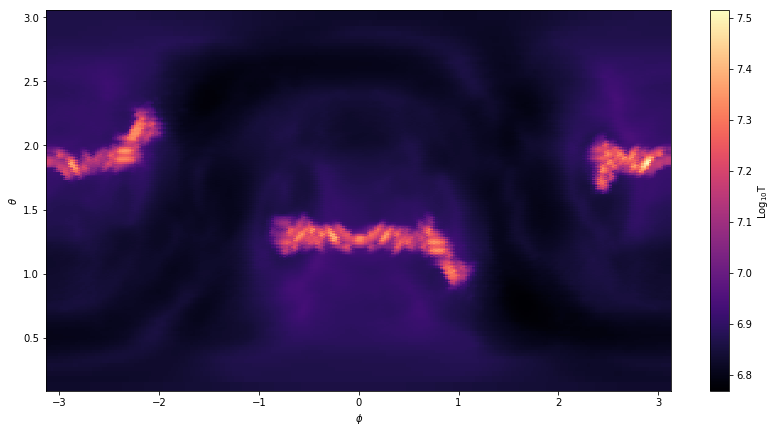

In [9]:
fig = plt.figure(figsize = (14,7))
ax = plt.subplot()
h = everywhere
z = h._cellParamVecs[:,:,0]
patches = plt.pcolormesh(h._phi,
                        h._theta,
                        z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True)
plt.colorbar(label='Log$_{10}$T')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')

##### 3D Plot

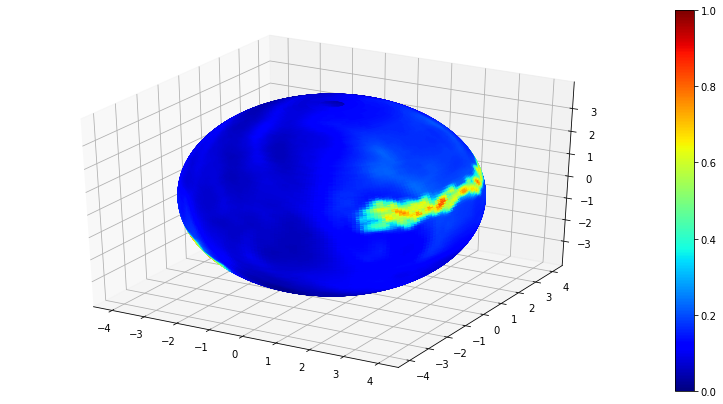

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

fig = plt.figure(figsize = (14,7))

za = everywhere._cellParamVecs[:,:,0]

norm = Normalize(vmin = np.min(za),vmax=np.max(za))
cmap = cm.jet
fc = cmap(norm(za))
ax = fig.add_subplot(111, projection='3d')
radius = 4.0
X = radius*np.sin(everywhere._theta)*np.cos(everywhere._phi)
Y = radius*np.sin(everywhere._theta)*np.sin(everywhere._phi)
Z = radius*np.cos(everywhere._theta)
surf = ax.plot_surface(X,Y,Z,rstride=1,cstride=1,facecolors=fc, linewidth=1,shade=False) 
#surf = ax.plot_surface(everywhere._theta,everywhere._phi,za,facecolors = fc)
a = np.array( [1, 0, 1])

#Creates colorbar
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(a)
plt.colorbar(m)
#print(plt.cm.magma(za))

#### Plot the pulse

2.7656570289799486e+41 (1, 1, 128, 100)


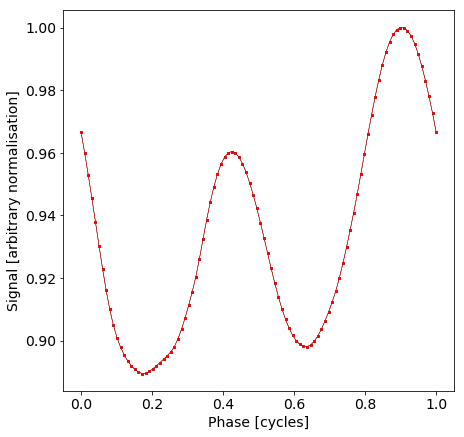

In [13]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8, yticks=None):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

    if yticks:
        axes.set_yticks(yticks)

def plot_pulse():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')

    temp = np.sum(photosphere.signal[0][0], axis=0)
    print(max(temp),np.shape(photosphere.signal))
    ax.plot(everywhere.phases_in_cycles, temp/np.max(temp), 'o-', color='k', lw=0.5, markersize=2)
    temp = np.sum(photosphere.signal[0][0], axis=0)
    ax.plot(everywhere.phases_in_cycles, temp/np.max(temp), 'o-', color='r', lw=0.5, markersize=2)
    #veneer((0.05,0.2), (0.05,0.2), ax)
_ = plot_pulse()

#### Plot the 2D Pulse

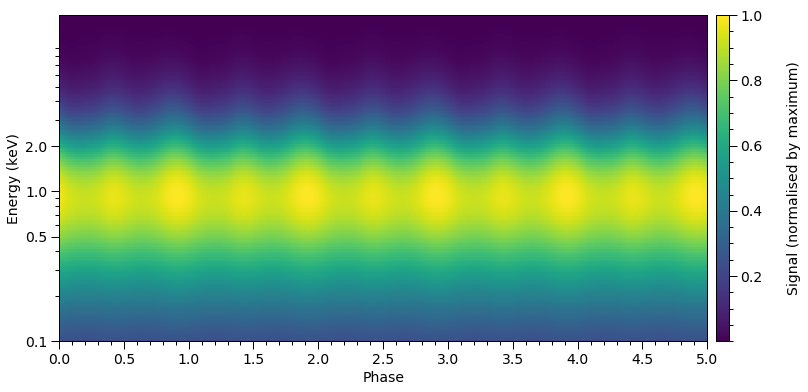

In [14]:
from xpsi.tools import phase_interpolator
def plot_2D_pulse(z, x, shift, y, ylabel,
                  num_rotations=5.0, res=5000, figsize=(12,6),
                  cm=cm.viridis,
                  yticks=None):
    """ Helper function to plot a phase-energy pulse.

    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.

    :param ndarray[n] x: Phases the signal is resolved at.

    :param tuple shift: Hot region phase parameters.

    :param ndarray[m] x: Energy values the signal is resolved at.

    """

    fig = plt.figure(figsize = figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      z[0], shift[0])
    interpolated += phase_interpolator(new_phases,
                                       x,
                                       z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, num_rotations])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax, yticks=yticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[0][0]),
              x=everywhere.phases_in_cycles,
              shift=[0,0],
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.1, 0.5,1.0,2.0])

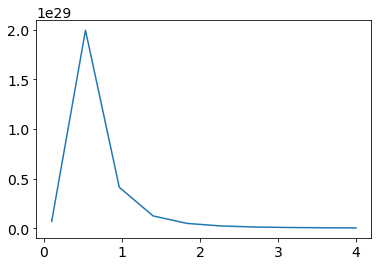

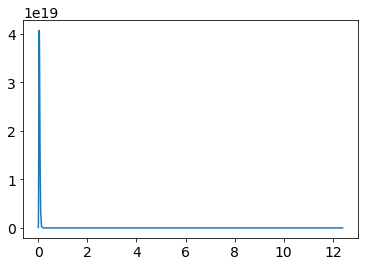

In [13]:
from scipy.constants import h,k,c

def blackbody_lam(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    lam = 1e-9 * lam # convert to metres
    return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

wa1 = np.linspace(0.1, 4, 10)   # wavelengths in nm
wa2 = np.linspace(0.1, 3.e2, 100)   # wavelengths in nm
T1 = 1.e7
T2 = 1.e5
#Lets transform nm to energy in keV
#Transform nm to m
energy1 = (h * c/(wa1 * 1.e-9) ) * 6.242e18/1.e3 #keV
energy2 = (h * c/(wa2 * 1.e-9) ) * 6.242e18/1.e3 #keV


plt.figure()
plt.plot(wa1,blackbody_lam(wa1,T1))
plt.figure()
plt.plot(energy2,blackbody_lam(wa2,T2))


In [14]:
import numpy as np

theta = np.linspace(0,np.pi,5)
phi = np.linspace(-np.pi,np.pi,10)
ph,th = np.meshgrid(phi,theta)
print(th[:,1],ph[1,:])
x = np.searchsorted(th[:,1], 1.8,side='left')
y = np.searchsorted(ph[x,:], 1.8,side='left')

print(x,y)
print(th[x,y],ph[x,y])
print(ph[x,y-1],ph[x,y],th[x-1,y],th[x,y])
#print(th)
#print(th[1][1],ph[1][1])
#print(th[1][2],ph[1][2])

#print(th[2][1],ph[2][1])
#print(th[2][2],ph[2][2])

#print(th[1,1],ph[1,1],th[2,1],ph[2,1])
#print(th[1,2],ph[1,2],th[2,2],ph[2,2])
#print(256/2)
d = np.zeros((5,5,1))
d[:,:,0] = 5
p = np.zeros((5,5))
p[:,:] = 10
d[...,:-1] = 5
#print(d[...,:])
#print(d[:,:,0].shape)

[0.         0.78539816 1.57079633 2.35619449 3.14159265] [-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
3 8
2.356194490192345 2.443460952792061
1.7453292519943293 2.443460952792061 1.5707963267948966 2.356194490192345
